# Decision Trees are suboptimal!

The decision tree is one of the first classification algorithms taught in any machine learing course. It is easy to understand and gives a very interpretable output. However, what most people don't realise is that it is all tree building algorithms (e.g. CART, ID3, C.45, MARS) are suboptimal. This is because building the optimal tree for a given dataset is NP hard, and would require an impractical amount of computation - especially for large datasets.

Whilst unavoidable in any practical application, it is worth being aware of these limitations in the algorithms and this notebook will expore this in some detail.

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
%%HTML
<style>
.text_cell_render {
font-size: 17px;
}
</style>

In [3]:
def generate_random_points(n, x_lims, y_lims):
    """
    Generates n random (x, y) pairs where: 
        x ~ U(x_lims[0], x_lims[1])
    and   
        y ~ U(y_lims[0], y_lims[1])
    """
    return list(zip([random.uniform(*x_lims) for _ in range(n)], 
                    [random.uniform(*y_lims) for _ in range(n)]))

def split_datasize(n, scale=0):
    """
    Splits the integer n into two value x, y where x + y = n,
    and x ~ U(n/2 - n*scale, n/2 + n*scale)
    """
    split_int = random.randint(int(n/2 - n*scale), int(n/2 + n*scale))
    return split_int, n - split_int

def generate_datasets(n):
    size_0, size_1 = split_datasize(n)    
    quadrant_sizes_0 = split_datasize(size_0)
    quadrant_coords = [
        [[-2, 0], [-1, 2]],
        [[0, 2], [-2, 1]],
        [[-2, 0], [-2, -1]],
        [[0, 2], [1, 2]]
    ]
    data_0 = generate_random_points(quadrant_sizes_0[0], *quadrant_coords[0]) \
            + generate_random_points(quadrant_sizes_0[1], *quadrant_coords[1])
    
    quadrant_sizes_1 = split_datasize(size_1)
    data_1 = generate_random_points(quadrant_sizes_1[0], *quadrant_coords[2]) \
            + generate_random_points(quadrant_sizes_1[1], *quadrant_coords[3])
    return data_0, data_1

def generate_suboptimal_dataset(n, min_depth):
    """
    Generates a dataset which has been suboptimally 
    classified by a decision tree
    """
    i = 0
    while True:
        i += 1
        x0, x1 = generate_datasets(n)
        y = [0] * len(x0) + [1] * len(x1)
        x = x0 + x1
        dt = DecisionTreeClassifier(random_state=2).fit(x, y)
        depth = dt.get_depth()
        if depth >= min_depth:
            print(f'Found a decision tree of depth {depth} after {i} tries')
            break
    return x0, x1, dt

def plot_suboptimal_dataset(x0, x1, dt, ax=None):
    # x0, x1, dt = generate_suboptimal_dataset(n, min_depth, tree_depth)
    xx, yy = np.meshgrid(np.arange(-2.1, 2.1, 0.01), np.arange(-2.1, 2.1, 0.01))
    Z = dt.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    # plot decision tree boundaries
    if ax is None:
        fig, ax = plt.subplots()
    ax.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.2)
    # plot datasets
    ax.plot([i[0] for i in x0], [i[1] for i in x0], '^', markersize=8)
    ax.plot([i[0] for i in x1], [i[1] for i in x1], 'o', markersize=8)
    # plot actual dataset boundaries
    ax.plot([0, 0], [-2.1, 2.1], 'g--')
    ax.plot([-2.1, 0], [-1, -1], 'g--')
    ax.plot([0, 2.1], [1, 1], 'g--')
    ax.set_xlabel('Feature_1')
    ax.set_ylabel('Feature_2')
    ax.set(xlim=[-2.1, 2.1], ylim = [-2.1, 2.1])

We start by generating a dataset where one class is sampled uniformly from the 2 blue sections below, and the other class is sampled from the orange sections. The dataset is delibrately generated so that it can be split by a decision tree of depth 2, as shown below.

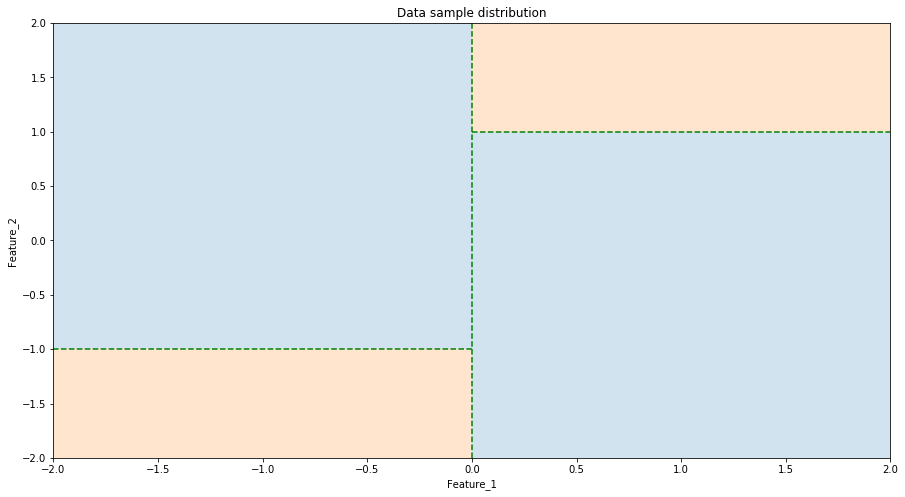

In [4]:
plt.rcParams['figure.figsize'] = [15, 8]
fig, ax = plt.subplots()
ax.fill([-2, 0, 0, -2], [-1, -1, 2, 2], 'C0', alpha=0.2)
ax.fill([0, 2, 2, 0], [-2, -2, 1, 1], 'C0', alpha=0.2)
ax.fill([-2, 0, 0, -2], [-2, -2, -1, -1], 'C1', alpha=0.2)
ax.fill([0, 2, 2, 0], [1, 1, 2, 2], 'C1', alpha=0.2)
ax.plot([0, 0], [-2, 2], 'g--')
ax.plot([-2, 0], [-1, -1], 'g--')
ax.plot([0, 2], [1, 1], 'g--')
ax.set_xlim((-2, 2))
ax.set_ylim((-2, 2))
ax.set_xlabel('Feature_1')
ax.set_ylabel('Feature_2')
ax.set_title('Data sample distribution');

For this dataset, an ideal decision tree should be able to split the data on the green dotted lines above, 
producing the following decision tree:

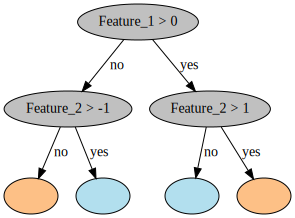

In [5]:
from graphviz import Digraph
u = Digraph('decision tree', node_attr={'color': 'black', 'fillcolor': 'gray', 'style': 'filled'})
u.attr(size='6,6')

u.edge('Feature_1 > 0', 'Feature_2 > -1', label=' no')
u.edge('Feature_1 > 0', 'Feature_2 > 1', label=' yes')
u.edge('Feature_2 > 1', '', label=' no')
u.edge('Feature_2 > 1', ' ', label=' yes')
u.edge('Feature_2 > -1', '  ', label=' no')
u.edge('Feature_2 > -1', '   ', label=' yes')

u.node('   ', color='black', fillcolor='lightblue2')
u.node(' ', color='black', fillcolor='/accent3/3')
u.node('  ', color='black', fillcolor='/accent3/3')
u.node('', color='black', fillcolor='lightblue2')
u

However, a CART decision tree fitted to this dataset produces the following results:

Found a decision tree of depth 3 after 2 tries


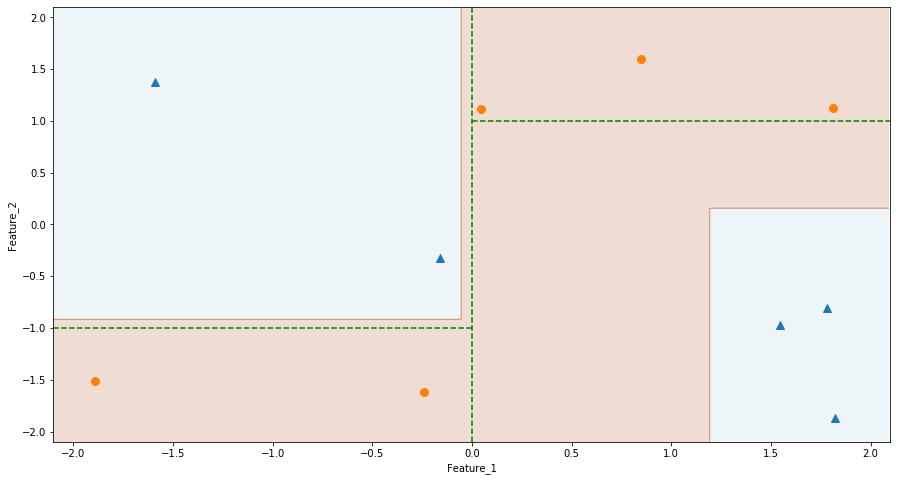

In [6]:
random.seed(9)
x0, x1, dt = generate_suboptimal_dataset(10, 3)
plot_suboptimal_dataset(x0, x1, dt)

In the plot above, the orange circles and blue squares are the data points for the two classes, and the background colours show the decision boundaries for the decision tree. The decision tree here was trained on 5 points of each class, and managed to find a tree of depth 3 which splits the data points. This is deeper than the optimal tree and would do a worse job at generalizing on new unseen data.

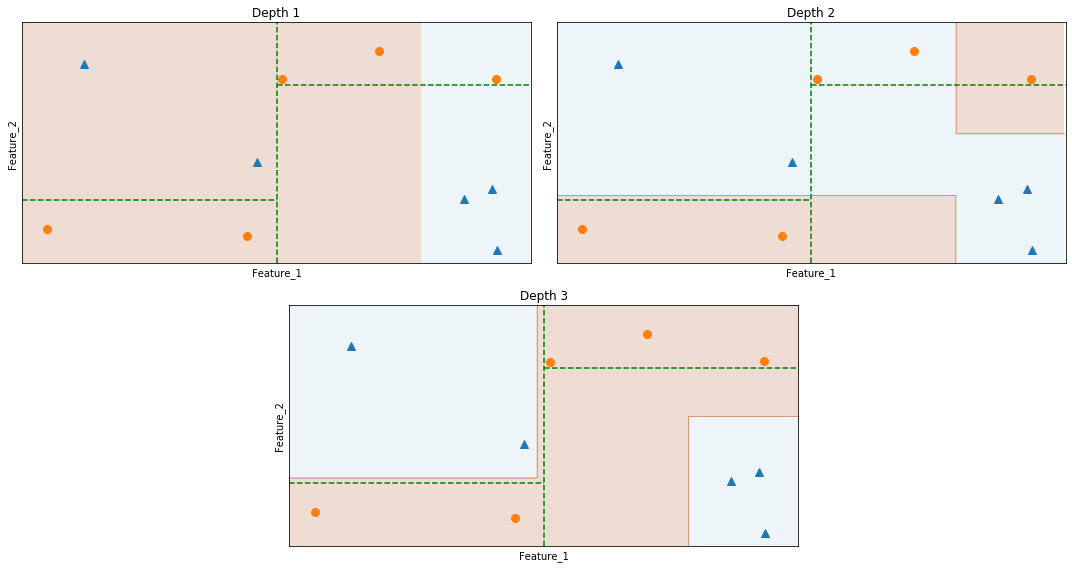

In [7]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(4, 4)
x = x0 + x1
y = [0]*len(x0) + [1]*len(x1)
plot_positions = [[slice(0, 2), slice(0, 2)], [slice(0, 2), slice(2, 4)], [slice(2, 4), slice(1, 3)]]
for i in range(1, 4):
    dt = DecisionTreeClassifier(max_depth=i, random_state=2).fit(x, y)
    ax = plt.subplot(gs[plot_positions[i - 1][0], plot_positions[i - 1][1]])
    plot_suboptimal_dataset(x0, x1, dt, ax=ax)
    ax.set_title(f'Depth {i}')
    ax.set_xticks([], [])
    ax.set_yticks([], [])
plt.tight_layout()

By plotting the decision boundaries at each depth of the decision tree, we can understand how the greedy algorithm came to generate a suboptimal tree. The decision tree starts by finding the best initial split of the data. It manages to find a split which has a gini inpurity of:

$$\\\frac{2}{6}\left(1 - \frac{2}{6}\right) + \frac{2}{6}\left(1 - \frac{2}{6}\right) = 0.409...$$

In comparison, the optimal tree at depth 1 has a gini inpurity of:

$$\frac{2}{4}\left(1 - \frac{2}{4}\right) + \frac{3}{6}\left(1 - \frac{3}{6}\right) = 0.5$$

A smaller gini impurity indicates a better split, swith 0.5 being the worst possible value. So at the first level, the CART decision tree algorithm did a better job.

However, by the second level the gini impurity of the decision tree algorithm drops to $0.222...$ while the optimal tree has an impurity of 0 indicating a perfect split. By being greedy at the first level, the decision tree algorithm failed to find the best possible solution after two levels.

It takes until the third level for the decision tree to completely separate the datasets.

In fact, it is not too hard to find a dataset where a decision tree will generate a far deeper tree, such as the one below at depth 7.

Found a decision tree of depth 7 after 13334 tries


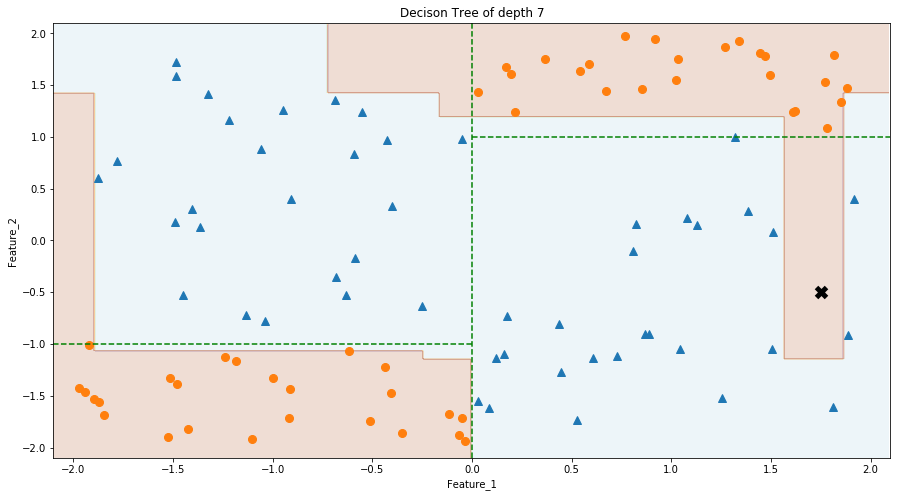

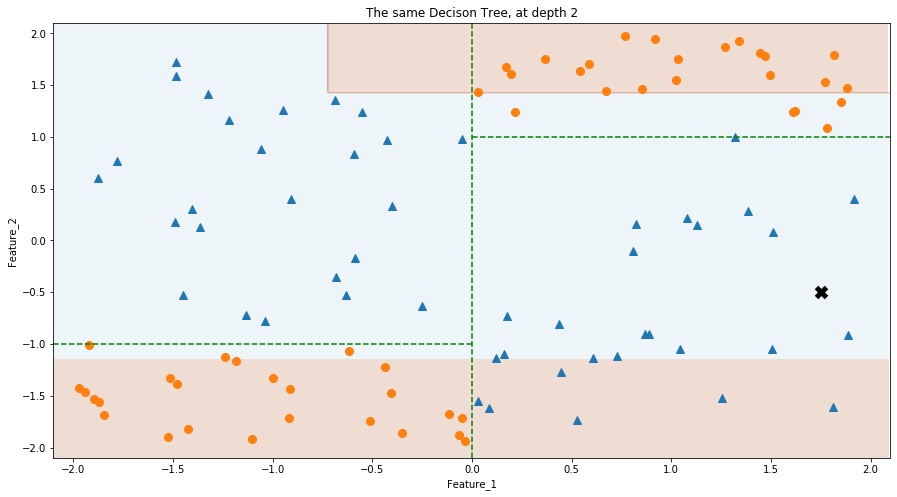

In [8]:
random.seed(13)
x0, x1, dt = generate_suboptimal_dataset(100, 7)
plot_suboptimal_dataset(x0, x1, dt)
plt.title('Decison Tree of depth 7')
plt.plot([1.75], [-0.5], 'kx', markersize=10, markeredgewidth=5)
dt = DecisionTreeClassifier(max_depth=2, random_state=2).fit(x0 + x1, [0]*len(x0) + [1]*len(x1))
plot_suboptimal_dataset(x0, x1, dt)
plt.title('The same Decison Tree, at depth 2')
plt.plot([1.75], [-0.5], 'kx', markersize=10, markeredgewidth=5);

The depth 7 tree manages to correctly classify all the data, but is clearly going to generalize poorly. For example, the unseen point $(1.75, -0.5)$ shown as a black cross will be misclassified as orange. By comparing the decision tree at depth 2 to the optimal tree, we can see that restricting the tree depth will not give a better solution here.

A way to potentially eveviate this problem is to use a random forest, which is a collection of decision trees trained on random subsets of the data.

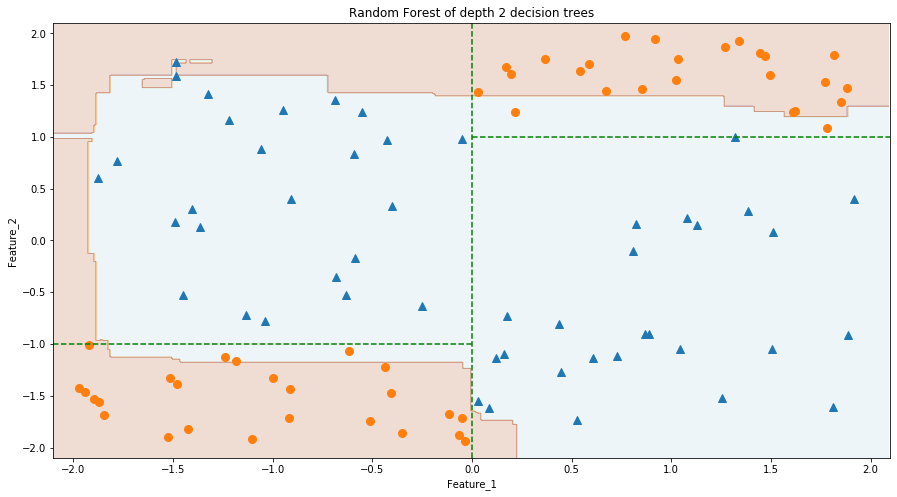

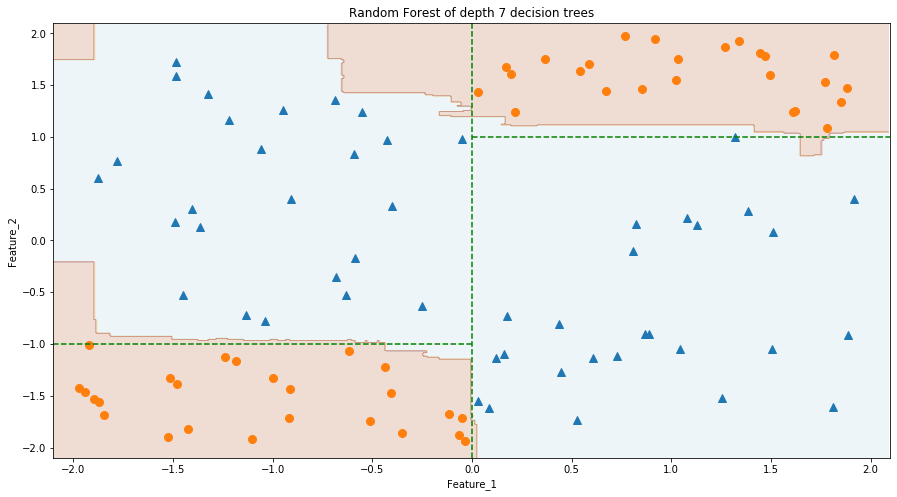

In [9]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=2).fit(x0 + x1, [0]*len(x0) + [1]*len(x1))
plot_suboptimal_dataset(x0, x1, rf)
plt.title('Random Forest of depth 2 decision trees')
rf = RandomForestClassifier(n_estimators=1000, max_depth=7).fit(x0 + x1, [0]*len(x0) + [1]*len(x1))
plot_suboptimal_dataset(x0, x1, rf)
plt.title('Random Forest of depth 7 decision trees');

A random forest of depth 2 trees still does a very poor job on the dataset, and there is a whoole region in the upper left where it fails to identify the correct class. However, a random forest of depth 7 trees does a better job on the dataset, and it is clear than the imperfections of each tree individually have been smoothed out by the forest. Although, it is interesting to note that the combination of 1000 decision trees of depth 7 has still failed to optimally split a dataset which can be split by a simple tree of depth 2!